In [0]:
spark.sql("USE CATALOG ons")
spark.sql("USE SCHEMA dados")

DataFrame[]

✅ Pergunta 1: Qual o perfil de usinas e combustíveis foram desativadas após 2000?

In [0]:
%sql
-- desativação após 2000 por tipo de usina
CREATE OR REPLACE TABLE capacidade_geracao_1_1_desativacao_por_tipo_usina AS
SELECT nom_tipousina,
       COUNT(*) AS qtd_usinas,
       round(SUM(val_potenciaefetiva),0) AS soma_potencia_MW
FROM ons.dados.capacidade_geracao
WHERE dat_desativacao IS NOT NULL
  AND YEAR(dat_desativacao) >= 2000
GROUP BY nom_tipousina
ORDER BY qtd_usinas DESC;

-- Consultar os dados para visualização
SELECT * FROM capacidade_geracao_1_1_desativacao_por_tipo_usina;

nom_tipousina,qtd_usinas,soma_potencia_MW
TÉRMICA,959,6211.0
FOTOVOLTAICA,3,50.0


In [0]:
%sql
-- desativação após 2000 por combustível
CREATE OR REPLACE TABLE capacidade_geracao_1_2_desativacao_por_combustivel AS
SELECT 
  nom_combustivel,
  COUNT(*) AS qtd_usinas,
  ROUND(SUM(val_potenciaefetiva), 0) AS soma_potencia_MW,
  ROUND(
    100 * SUM(val_potenciaefetiva) 
    / SUM(SUM(val_potenciaefetiva)) OVER (),
    1
  ) AS pareto
FROM ons.dados.capacidade_geracao
WHERE dat_desativacao IS NOT NULL
  AND YEAR(dat_desativacao) >= 2000
GROUP BY nom_combustivel
ORDER BY qtd_usinas DESC;

-- Consultar os dados para visualização
select * from capacidade_geracao_1_2_desativacao_por_combustivel;

nom_combustivel,qtd_usinas,soma_potencia_MW,pareto
ÓLEO DIESEL,772,2020.0,32.3
GÁS,64,1513.0,24.2
MULTI-COMBUSTÍVEL DIESEL/ÓLEO,61,590.0,9.4
ÓLEO COMBUSTÍVEL,29,706.0,11.3
CARVÃO,13,558.0,8.9
BIOMASSA,13,326.0,5.2
MULTI-COMBUSTÍVEL GÁS/DIESEL,5,347.0,5.5
FOTOVOLTAICA,3,50.0,0.8
RESÍDUO CICLO COMBINADO,2,151.0,2.4


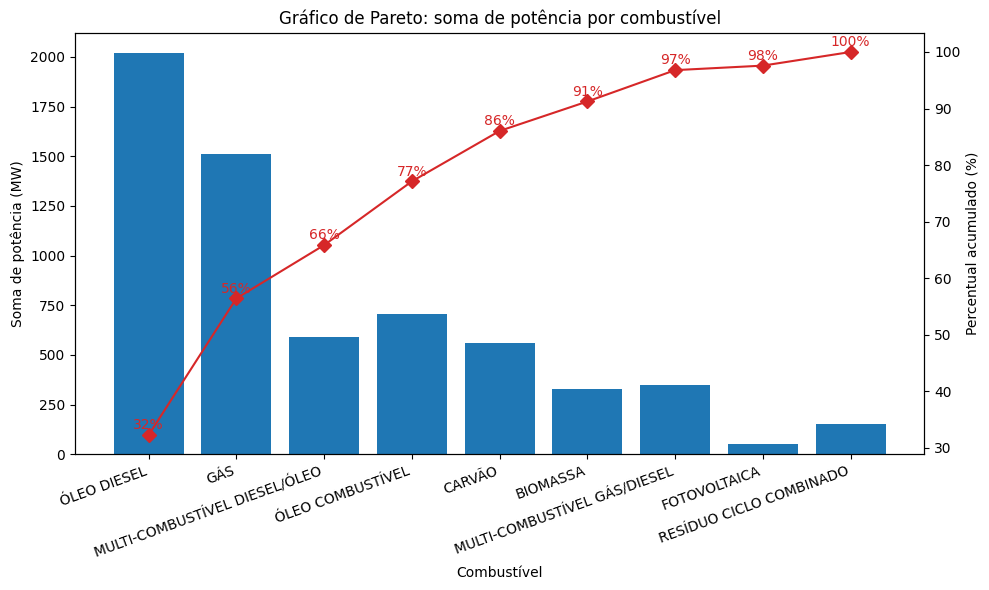

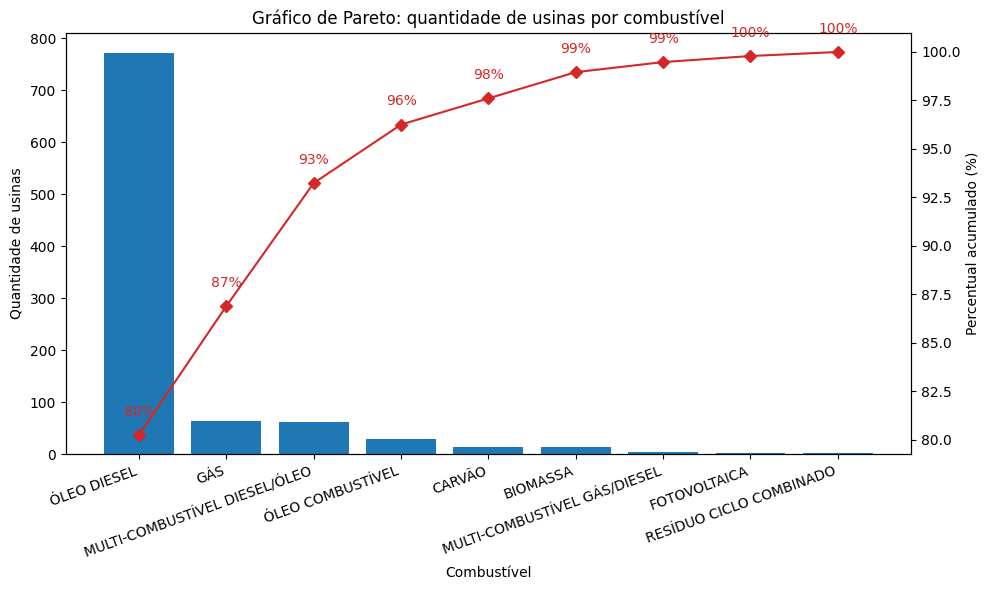

In [0]:
# Importar bibliotecas
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum
import matplotlib.pyplot as plt

# Iniciar sessão Spark
spark = SparkSession.builder.appName("VisualizacaoONS").getOrCreate()

df_spark = spark.table("ons.dados.capacidade_geracao_1_2_desativacao_por_combustivel")
# display(df_1_2)

# Ordenar por qtd_usinas decrescente
df_sorted = df_spark.orderBy(col("qtd_usinas").desc())

# Converter para Pandas para plotar
df_pd = df_sorted.toPandas()

# Calcular percentual acumulado para Pareto
df_pd["cum_percent"] = df_pd["soma_potencia_MW"].cumsum() / df_pd["soma_potencia_MW"].sum() * 100

# =============================
# Gráfico de Pareto - Potencia
# =============================
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.bar(df_pd["nom_combustivel"], df_pd["soma_potencia_MW"], color="C0")
ax1.set_ylabel("Soma de potência (MW)")
ax1.set_xlabel("Combustível")
ax1.set_xticks(range(len(df_pd)))
ax1.set_xticklabels(df_pd["nom_combustivel"], rotation=20, ha="right")
ax1.set_title("Gráfico de Pareto: soma de potência por combustível")

# Linha acumulada
ax2 = ax1.twinx()
ax2.plot(df_pd["nom_combustivel"], df_pd["cum_percent"], color="C3", marker="D", ms=7)
ax2.set_ylabel("Percentual acumulado (%)")

# Mostrar valores na linha
for x_val, y_val in zip(df_pd["nom_combustivel"], df_pd["cum_percent"]):
    ax2.text(x_val, y_val+1, f"{y_val:.0f}%", ha="center", color="C3")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
print()

# ===============================
# Gráfico de Pareto - Quantidade
# ===============================
df_ord = df_spark.orderBy(col("qtd_usinas").desc())

# Converter para Pandas para plotar
df_pd = df_ord.toPandas()

# Calcular percentual acumulado
df_pd["cum_pct_qtd"] = df_pd["qtd_usinas"].cumsum() / df_pd["qtd_usinas"].sum() * 100

# Plot Pareto para quantidade
fig, ax3 = plt.subplots(figsize=(10,6))
ax3.bar(df_pd["nom_combustivel"], df_pd["qtd_usinas"], color="C0")
ax3.set_xlabel("Combustível")
ax3.set_xticks(range(len(df_pd)))
ax3.set_xticklabels(df_pd["nom_combustivel"], rotation=20, ha="right")
ax3.set_ylabel("Quantidade de usinas")
ax3.set_title("Gráfico de Pareto: quantidade de usinas por combustível")

# Linha acumulada
ax4 = ax3.twinx()
ax4.plot(df_pd["nom_combustivel"], df_pd["cum_pct_qtd"], color="C3", marker="D", ms=6)
ax4.set_ylabel("Percentual acumulado (%)")

# Anotar valores
for x_val, y_val in zip(df_pd["nom_combustivel"], df_pd["cum_pct_qtd"]):
    ax4.text(x_val, y_val+1, f"{y_val:.0f}%", ha="center", color="C3")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


#### Resposta:

A partir dos anos 2000, ocorreram desativações de apenas 2 tipos de usinas. Destacam-se as TÉRMICA com 959 unidades e totalizando 6.211 MW. Tivemos ainda 3 unidades de usinas Fotovoltaica com apenas 50 MW no total. <br>
Por TIPO DE COMBUSTÍVEL, a prevalência foram as usinas a Óleo Diesel, com 772 unidades (80%), somando 2.020 MW (32%). Tivemos ainda 64 unidades (7%) a Gás, que acumularam 1.513 MW (24%). E ainda usinas a Óleo Combustível, Biomassa, Carvão e outros tipos de combustíveis.

#### Discussão:
A desativação concentra-se em usinas térmicas principalmente pelo impacto ambiental pelo uso de combustíveis fósseis.

✅ 2. Quais tipos de usinas e combustíveis mais cresceram após 1990?

In [0]:
%sql
-- ativação após 1990 por tipo de usina
CREATE OR REPLACE TABLE capacidade_geracao_2_1_ativacao_por_tipo_usina AS
SELECT FLOOR(YEAR(dat_entradaoperacao)/10)*10 AS decada,
       nom_tipousina,
       COUNT(*) AS qtd_usinas
FROM ons.dados.capacidade_geracao
WHERE YEAR(dat_entradaoperacao) >= 1990
GROUP BY FLOOR(YEAR(dat_entradaoperacao)/10)*10, nom_tipousina
ORDER BY decada, qtd_usinas DESC;

-- Consultar os dados para visualização
select * from capacidade_geracao_2_1_ativacao_por_tipo_usina
limit 5

decada,nom_tipousina,qtd_usinas
1990,HIDROELÉTRICA,82
1990,TÉRMICA,68
2000,TÉRMICA,958
2000,HIDROELÉTRICA,154
2000,EOLIELÉTRICA,15


decada         1990   2000    2010    2020
nom_tipousina                             
EOLIELÉTRICA    0.0   15.0  1091.0  1022.0
FOTOVOLTAICA    0.0    0.0   131.0   907.0
HIDROELÉTRICA  82.0  154.0   264.0     8.0
NUCLEAR         0.0    1.0     0.0     0.0
TÉRMICA        68.0  958.0   225.0   174.0


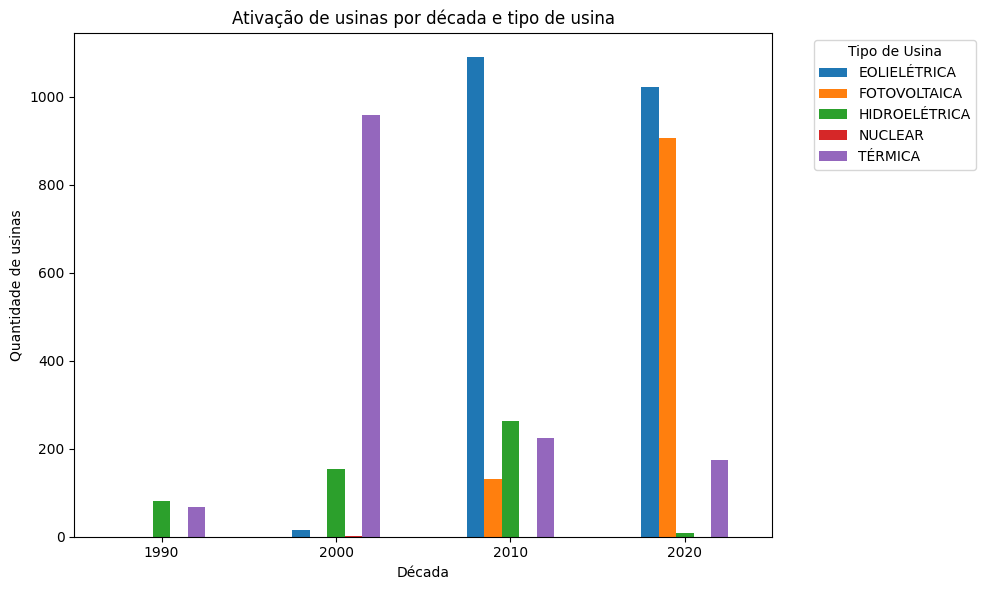

In [0]:
# Importar bibliotecas
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum
import matplotlib.pyplot as plt

# Iniciar sessão Spark
spark = SparkSession.builder.appName("VisualizacaoONS").getOrCreate()

df_spark = spark.table("ons.dados.capacidade_geracao_2_1_ativacao_por_tipo_usina")

# Converter para Pandas para plotar
df_pd = df_spark.toPandas()

# Pivotar os dados para ter décadas nas linhas e tipos de usina nas colunas
pivot = df_pd.pivot(index='decada', columns='nom_tipousina', values='qtd_usinas').fillna(0)
print(pivot.T)

# Criar gráfico de barras agrupado
fig, ax = plt.subplots(figsize=(10,6))
pivot.plot(kind='bar', ax=ax)

# Ajustes visuais
ax.set_xlabel('Década')
ax.set_ylabel('Quantidade de usinas')
ax.set_title('Ativação de usinas por década e tipo de usina')
ax.legend(title='Tipo de Usina', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



In [0]:
%sql
-- ativação após 1990 por combustível
CREATE OR REPLACE TABLE capacidade_geracao_2_2_ativacao_por_combustivel AS
SELECT FLOOR(YEAR(dat_entradaoperacao)/10)*10 AS decada,
       nom_combustivel,
       COUNT(*) AS qtd_usinas
FROM ons.dados.capacidade_geracao
WHERE YEAR(dat_entradaoperacao) >= 1990
GROUP BY FLOOR(YEAR(dat_entradaoperacao)/10)*10, nom_combustivel
ORDER BY decada, qtd_usinas DESC;

-- Consultar os dados para visualização
select * from capacidade_geracao_2_2_ativacao_por_combustivel
limit 10

decada,nom_combustivel,qtd_usinas
1990,HIDRÁULICA,82
1990,GÁS,32
1990,ÓLEO COMBUSTÍVEL,14
1990,ÓLEO DIESEL,9
1990,MULTI-COMBUSTÍVEL DIESEL/ÓLEO,7
1990,CARVÃO,4
1990,BIOMASSA,1
1990,RESÍDUO CICLO COMBINADO,1
2000,ÓLEO DIESEL,769
2000,HIDRÁULICA,154


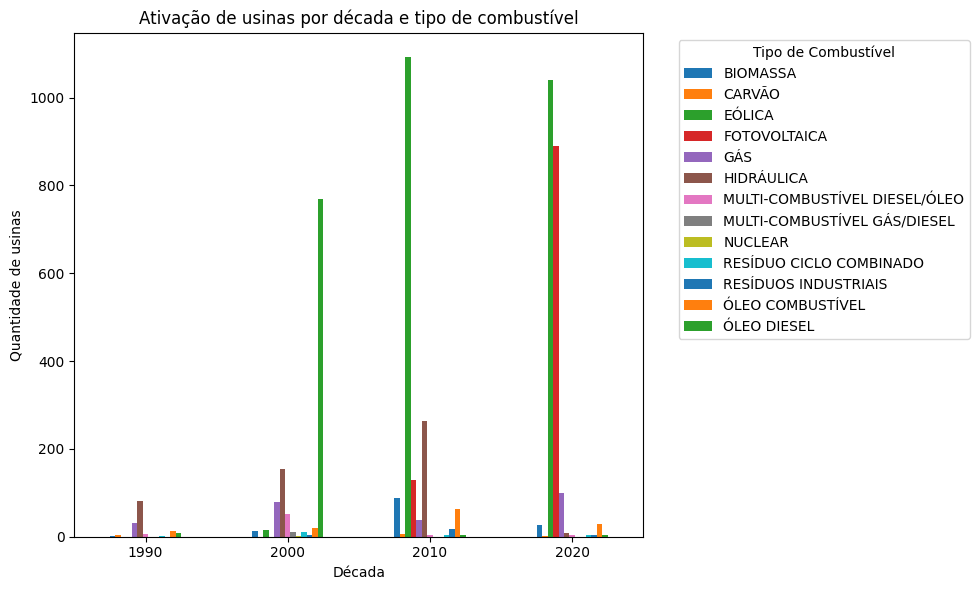

In [0]:
# Importar bibliotecas
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum
import matplotlib.pyplot as plt

# Iniciar sessão Spark
spark = SparkSession.builder.appName("VisualizacaoONS").getOrCreate()

df_spark = spark.table("ons.dados.capacidade_geracao_2_2_ativacao_por_combustivel")

# Converter para Pandas para plotar
df_pd = df_spark.toPandas()

# Pivotar os dados para ter décadas nas linhas e tipos de usina nas colunas
pivot = df_pd.pivot(index='decada', columns='nom_combustivel', values='qtd_usinas').fillna(0)

# Criar gráfico de barras agrupado
fig, ax = plt.subplots(figsize=(10,6))
pivot.plot(kind='bar', ax=ax)

# Ajustes visuais
ax.set_xlabel('Década')
ax.set_ylabel('Quantidade de usinas')
ax.set_title('Ativação de usinas por década e tipo de combustível')
ax.legend(title='Tipo de Combustível', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Resposta:

Consegue-se observar que ainda houve entrada de usinas térmicas com relevante participação até os anos 2000, notadamente abastecidas por Óleo Diesel, mas que a partir dos anos 2010 prevalecem usinas com energia renovável: Eólicas e Fotovoltáica.
- Eólicas: explosão após 2010 (1.091 unidades) e 2020 (1.017).
- Fotovoltaicas: 131 (2010) e 900 (2020).
- Térmicas: pico em 2000 (958 unidades) seguida de declínio nas décadas seguintes.

#### Discussão:
Mostra mudança estrutural: renováveis crescem fortemente após 2010, enquanto térmicas dominaram a década de 2000.

✅ 3. Evolução da participação renovável vs não renovável por década

In [0]:
%sql
-- participação renovaveis e não renovaveis
CREATE OR REPLACE TABLE capacidade_geracao_3_1_participacao_renovaveis AS
WITH base AS (
    SELECT
        nom_combustivel, val_potenciaefetiva, dat_entradaoperacao, dat_desativacao,
        CASE WHEN nom_combustivel IN ('EÓLICA','HIDRÁULICA','FOTOVOLTAICA','BIOMASSA')
             THEN 'Renovável' ELSE 'Não Renovável' END AS categoria
    FROM ons.dados.capacidade_geracao
),
decadas AS (
    SELECT DISTINCT FLOOR(YEAR(dat_entradaoperacao)/10)*10 AS decada
    FROM base
    WHERE dat_entradaoperacao IS NOT NULL
)
SELECT
    d.decada, b.categoria,
    round(SUM(CASE WHEN b.dat_entradaoperacao <= MAKE_DATE(d.decada+9,12,31) THEN b.val_potenciaefetiva ELSE 0 END)
    - SUM(CASE WHEN b.dat_desativacao IS NOT NULL AND b.dat_desativacao <= MAKE_DATE(d.decada+9,12,31) THEN b.val_potenciaefetiva ELSE 0 END),0)
    AS capacidade_liquida_MW
FROM decadas d
JOIN base b ON 1=1
GROUP BY d.decada, b.categoria
ORDER BY d.decada, b.categoria;

-- Consultar os dados para visualização
select * from capacidade_geracao_3_1_participacao_renovaveis
limit 5

decada,categoria,capacidade_liquida_MW
1920,Não Renovável,0.0
1920,Renovável,162.0
1930,Não Renovável,0.0
1930,Renovável,406.0
1940,Não Renovável,0.0


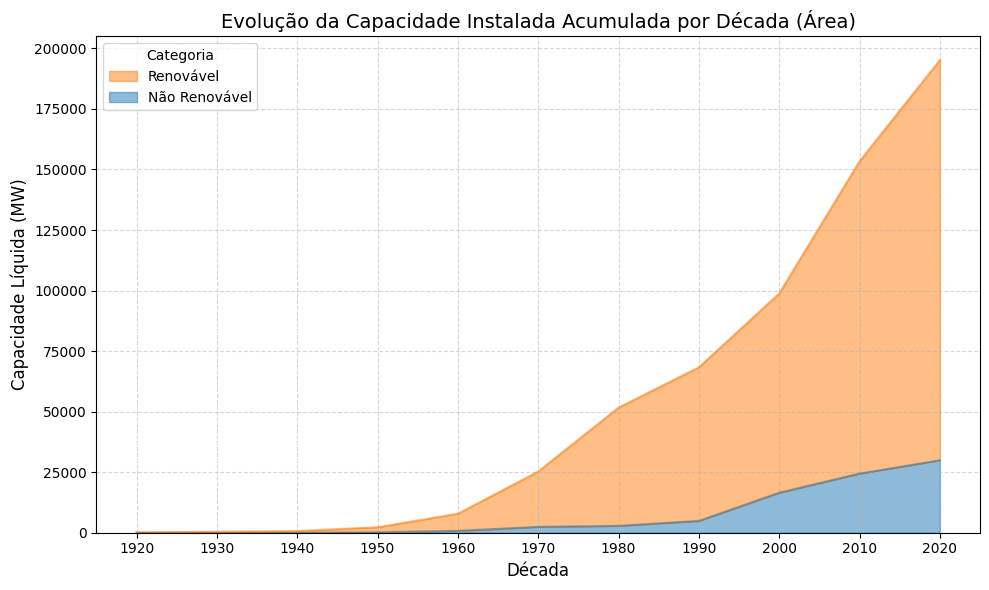

In [0]:
# Importar bibliotecas
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum
import matplotlib.pyplot as plt

# Iniciar sessão Spark
spark = SparkSession.builder.appName("VisualizacaoONS").getOrCreate()

df_spark = spark.table("ons.dados.capacidade_geracao_3_1_participacao_renovaveis")

# Converter para Pandas para plotar
df_pd = df_spark.toPandas()

# Criar uma tabela pivot: décadas como índice, categorias como colunas
df_pivot = df_pd.pivot(index='decada', columns='categoria', values='capacidade_liquida_MW')

# Plot do gráfico de área
ax = df_pivot.plot(kind='area', alpha=0.5, figsize=(10,6))

# Configuração dos títulos e rótulos
ax.set_title('Evolução da Capacidade Instalada Acumulada por Década (Área)', fontsize=14)
ax.set_xlabel('Década', fontsize=12)
ax.set_ylabel('Capacidade Líquida (MW)', fontsize=12)

# Ajustes visuais
ax.set_xticks(df_pivot.index)
ax.grid(linestyle='--', alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Categoria')
plt.tight_layout()

# Exibir o gráfico
plt.show()

#### Resposta:

A análise da inclinação da curva de capacidade dos renováveis por década revela uma tendência relevante de incremento principalmente a partir de 1960. Esse salto marca o início de um ciclo de grandes investimentos em hidrelétricas, consolidando as renováveis como base da matriz elétrica brasileira. A curva começa a se inclinar fortemente, sinalizando expansão acelerada.

Imperioso destacar a contribuição dos não renováveis entre 1990 e 2000, notadamente pelas entradas das usinas térmicas, como já supracitado.

Ainda em relação à curva de renováveis, é possível observar outro incremento líquido significativo a partir dos anos 2000. Esse “bump” coincide com a introdução das primeiras usinas eólicas e fotovoltaicas, além da continuidade das hidrelétricas. É um segundo impulso na transição energética, diversificando a matriz.


Tendência mais flat após 2000 para os não renováveis, indicando uma desaceleração nas implementações desse tipo de usina, com queda na taxa de crescimento.

#### Discussão:
A curva das renováveis mostra um padrão típico de transição energética:

- Fase inicial (1960–1980): crescimento acelerado, dominado por hidrelétricas.
- Fase de diversificação (1990–2010): entrada de novas tecnologias (eólica, solar).
- Fase de maturidade (após 2010): expansão continua, mas com inclinação menor, refletindo desafios de integração e políticas mais equilibradas.

✅ 4. Potência média de usinas ativas vs desativadas

In [0]:
%sql
-- quantitativo de desativações
CREATE OR REPLACE TABLE capacidade_geracao_4_1_quantitativo_desativacoes AS
SELECT CASE WHEN dat_desativacao IS NULL THEN 'Ativa' ELSE 'Desativada' END AS status,
       COUNT(*) AS qtd_usinas,
       round(AVG(val_potenciaefetiva),1) AS potencia_media_MW,
       round(SUM(val_potenciaefetiva),1) AS potencia_total_MW
FROM ons.dados.capacidade_geracao
GROUP BY CASE WHEN dat_desativacao IS NULL THEN 'Ativa' ELSE 'Desativada' END;

-- Consultar os dados para visualização
select * from capacidade_geracao_4_1_quantitativo_desativacoes


status,qtd_usinas,potencia_media_MW,potencia_total_MW
Desativada,966,6.6,6377.5
Ativa,4484,43.5,195225.0


#### Resultado:

É possível notar que a potência média das usinas que foram desativadas é bem menor que a potência média das usinas ativas, apenas 15%,
- Ativas: média 43,6 MW.
- Desativadas: média 6,6 MW.

#### Discussão:
Unidades menores são mais vulneráveis à desativação, útil para estudos de vida útil e planejamento.

✅ 5. Relação idade vs probabilidade de desativação

In [0]:
%sql
-- relação idade e desativação
CREATE OR REPLACE TABLE capacidade_geracao_5_1_relacao_idade_desativacao AS
SELECT FLOOR(DATEDIFF(CURRENT_DATE, dat_entradaoperacao)/365/10)*10 AS inicio_faixa_idade,
       CONCAT(FLOOR(DATEDIFF(CURRENT_DATE, dat_entradaoperacao)/365/10)*10, '-', FLOOR(DATEDIFF(CURRENT_DATE, dat_entradaoperacao)/365/10)*10+9) AS faixa_idade,
       COUNT(*) AS total_usinas,
       SUM(CASE WHEN dat_desativacao IS NOT NULL THEN 1 ELSE 0 END) AS desativadas,
       ROUND(SUM(CASE WHEN dat_desativacao IS NOT NULL THEN 1 ELSE 0 END)*100.0/COUNT(*),1) AS perc_desativadas
FROM ons.dados.capacidade_geracao
WHERE dat_entradaoperacao IS NOT NULL
GROUP BY CONCAT(FLOOR(DATEDIFF(CURRENT_DATE, dat_entradaoperacao)/365/10)*10, '-', FLOOR(DATEDIFF(CURRENT_DATE, dat_entradaoperacao)/365/10)*10+9),
         FLOOR(DATEDIFF(CURRENT_DATE, dat_entradaoperacao)/365/10)*10
ORDER BY inicio_faixa_idade;

-- Consultar os dados para visualização
select * from capacidade_geracao_5_1_relacao_idade_desativacao
limit 5

inicio_faixa_idade,faixa_idade,total_usinas,desativadas,perc_desativadas
0,0-9,2967,52,1.8
10,10-19,1110,145,13.1
20,20-29,924,714,77.3
30,30-39,130,34,26.2
40,40-49,108,7,6.5


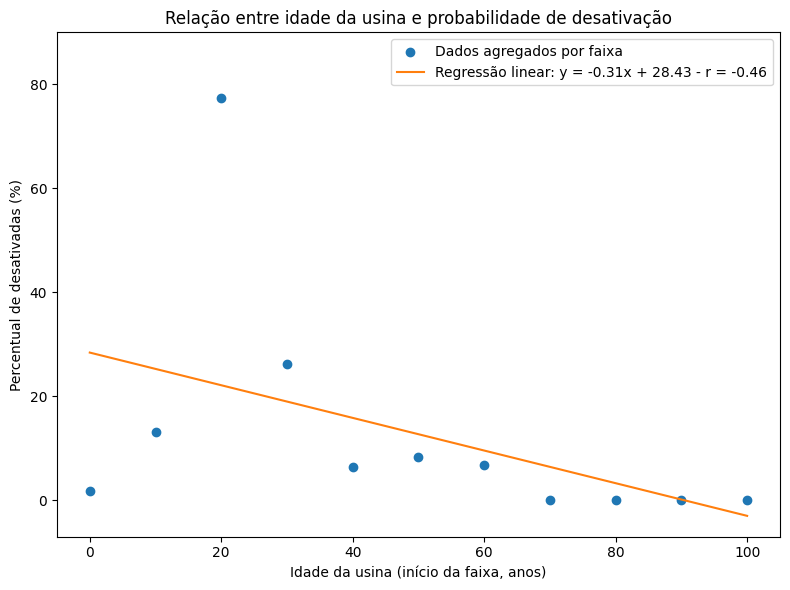

In [0]:
# Importar bibliotecas
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum
import matplotlib.pyplot as plt
import numpy as np

# Iniciar sessão Spark
spark = SparkSession.builder.appName("VisualizacaoONS").getOrCreate()
df_spark = spark.table("ons.dados.capacidade_geracao_5_1_relacao_idade_desativacao")
# Converter para Pandas para plotar
df_pd = df_spark.toPandas()

# Extrair variáveis: início da faixa de idade (anos) e percentual de desativadas
x = df_pd['inicio_faixa_idade'].astype(float).values
y = df_pd['perc_desativadas'].astype(float).values

# Ajuste linear simples
slope, intercept = np.polyfit(x, y, 1)

# Correlação de Pearson
r = np.corrcoef(x, y)[0, 1]

# Geração da linha de regressão
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, color='C0', label='Dados agregados por faixa')
ax.plot(x_line, y_line, color='C1',
        label=f'Regressão linear: y = {slope:.2f}x + {intercept:.2f} - r = {r:.2f}')
ax.set_xlabel('Idade da usina (início da faixa, anos)')
ax.set_ylabel('Percentual de desativadas (%)')
ax.set_title('Relação entre idade da usina e probabilidade de desativação')
ax.legend()
ax.set_ylim(top=90)
plt.tight_layout()
plt.show()



#### Resultado:

A anélise da relação idade da usina vs percentual de desativação com os dados agregados por faixa mostra-nos uma correlação de Pearson de −0,46 (correlação negativa moderada).

#### Discussão:

Não há evidência de que usinas de maior idade sejam mais propensas à desativação. Pelo contrário, a tendência geral é ligeiramente negativa, mas isso ocorre porque os dados são muito dispersos:

- Faixa 0–9 anos: ~1,7% desativadas
- Faixa 10–19 anos: ~13,5%
- Faixa 20–29 anos: salta para ~77,3%
- Depois disso, cai nas faixas seguintes.

Esse comportamento não é monotônico, então um modelo linear não explica bem a variação. A maior taxa está concentrada em uma faixa intermediária (20–29 anos), não nas mais velhas.

✅ 6. Concentração de capacidade por agente nos últimos 10 anos

In [0]:
%sql
-- concentração de agentes
CREATE OR REPLACE TABLE capacidade_geracao_6_1_concentracao_agentes AS
SELECT nom_agenteproprietario,
       COUNT(*) AS qtd_usinas,
       round(SUM(val_potenciaefetiva),0) AS soma_potencia_MW
FROM ons.dados.capacidade_geracao
WHERE YEAR(dat_entradaoperacao) >= YEAR(CURRENT_DATE)-10
GROUP BY nom_agenteproprietario
ORDER BY soma_potencia_MW DESC
LIMIT 10;

-- Consultar os dados para visualização
select * from capacidade_geracao_6_1_concentracao_agentes
limit 5

nom_agenteproprietario,qtd_usinas,soma_potencia_MW
NORTE ENERGIA SA,24,11233.0
JIRAU ENERGIA,30,2250.0
ENEVA,14,1882.0
TELES PIRES,5,1820.0
UTE GNA II,4,1673.0


#### Resultado:

- Norte Energia SA: 11.233 MW.
- Jirau Energia: 2250 MW.
- Eneva: 1.882 MW.

#### Discussão:

Poucos agentes concentram grande capacidade, importante para análise de dependência e governança.

✅ 7. Tendência de diversificação de combustíveis nas térmicas (Índice de Shannon)

In [0]:
%sql
-- diversificação de combustíveis nas térmicas
CREATE OR REPLACE TABLE capacidade_geracao_7_1_diversificacao_combustiveis_termicas AS
SELECT decada,
       nom_combustivel,
       round(SUM(val_potenciaefetiva),0) AS soma_potencia_MW
FROM (
    SELECT FLOOR(YEAR(dat_entradaoperacao)/10)*10 AS decada,
           nom_combustivel,
           val_potenciaefetiva
    FROM ons.dados.capacidade_geracao
    WHERE nom_tipousina LIKE '%TÉRMICA%'
) t
GROUP BY decada, nom_combustivel
ORDER BY decada, soma_potencia_MW DESC;

select * from capacidade_geracao_7_1_diversificacao_combustiveis_termicas
limit 5


decada,nom_combustivel,soma_potencia_MW
1950,GÁS,100.0
1950,RESÍDUO CICLO COMBINADO,95.0
1960,ÓLEO COMBUSTÍVEL,240.0
1960,CARVÃO,162.0
1960,GÁS,100.0


In [0]:
# Load SQL result into Spark DataFrame
df = spark.sql("""
SELECT decada, nom_combustivel,
       SUM(val_potenciaefetiva) AS soma_potencia_MW
FROM (
    SELECT FLOOR(YEAR(dat_entradaoperacao)/10)*10 AS decada,
           nom_combustivel, val_potenciaefetiva
    FROM ons.dados.capacidade_geracao
    WHERE nom_tipousina LIKE '%TÉRMICA%'
) t
GROUP BY decada, nom_combustivel
ORDER BY decada, soma_potencia_MW DESC
""")
# Convert to pandas for easier manipulation
pdf = df.toPandas()

# Pivot to get fuel sums per decade
sum_fuel_by_decade = pdf.pivot_table(
    index='decada',
    columns='nom_combustivel',
    values='soma_potencia_MW',
    fill_value=0
)

# Shannon index function
def shannon_index(row):
    proportions = row / row.sum()
    proportions = proportions[proportions > 0]
    return -np.sum(proportions * np.log(proportions))

# Calculate diversity for each decade
diversity = {dec: shannon_index(sum_fuel_by_decade.loc[dec]) for dec in sum_fuel_by_decade.index}

for decada, valor in diversity.items():
    print(f"Década: {decada} - Shannon: {valor:.2f}")

Década: 1950 - Shannon: 0.69
Década: 1960 - Shannon: 1.31
Década: 1970 - Shannon: 0.81
Década: 1980 - Shannon: 0.16
Década: 1990 - Shannon: 1.60
Década: 2000 - Shannon: 1.52
Década: 2010 - Shannon: 1.77
Década: 2020 - Shannon: 1.10


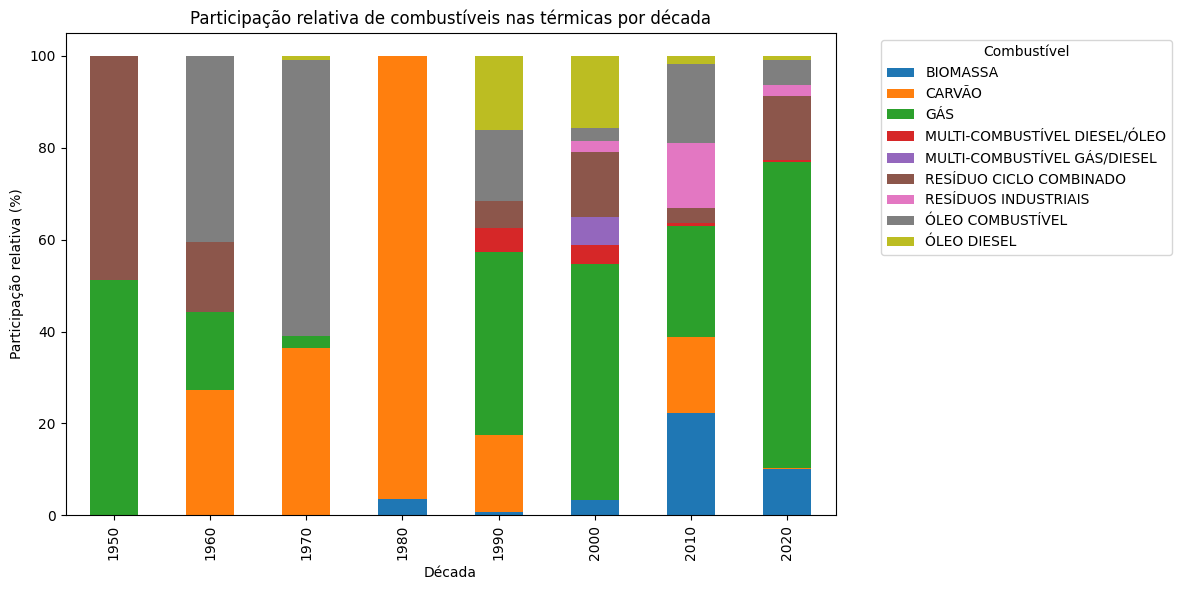

In [0]:
# Importar bibliotecas
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum
import matplotlib.pyplot as plt

# Iniciar sessão Spark
spark = SparkSession.builder.appName("VisualizacaoONS").getOrCreate()

df_spark = spark.table("ons.dados.capacidade_geracao_7_1_diversificacao_combustiveis_termicas")

# Converter para Pandas para plotar
df_pd = df_spark.toPandas()

# Pivot: linhas = décadas, colunas = combustíveis, valores = soma de potência
pivot = df_pd.pivot_table(index='decada', columns='nom_combustivel',
                       values='soma_potencia_MW', aggfunc='sum', fill_value=0)

# Normalização para percentuais por década
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100

# Gráfico de barras empilhadas (100%)
fig, ax = plt.subplots(figsize=(12, 6))
pivot_pct.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Década')
ax.set_ylabel('Participação relativa (%)')
ax.set_title('Participação relativa de combustíveis nas térmicas por década')
ax.legend(title='Combustível', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Resultado:

O índice de Shannon representa a diversidade do mix de combustíveis nas térmicas ao longo das décadas.

Pico de diversidade em 2010 (1,77), queda em 2020 (1,10). E nos anos 1908 o menos valor, representando a menor diversificação.

#### Discussão:

É possível visualizar:

- 1950 (0,69) → 2 combustíveis, quase equilíbrio perfeito.
- 1960 (1,31) → 4 combustíveis, bem distribuídos.
- 1980 (0,16) → diversidade mínima, dominância total.
- 2010 (1,77) → maior diversidade, mix mais equilibrado.

#### Discussão Geral

Essas análises mostram:

- Desativações: foco em térmicas fósseis e pequenas unidades.
- Expansão: renováveis dominam após 2010; térmicas foram relevantes nos anos 2000.
- Sustentabilidade: participação renovável recupera após queda nos anos 2000.
- Perfil tecnológico: eólica e solar correlacionadas com anos recentes.
- Diversidade: maior nos anos 2010, depois consolidação.